<a href="https://colab.research.google.com/github/Alex-Ukraine/ml-selfedu/blob/main/transfer_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Style Transfer - Стилизация изображений

Леон Гатис, 2015:
* степень соответствия преобразованного изображения исходному;
* степень стилизации преобразованного изображения.

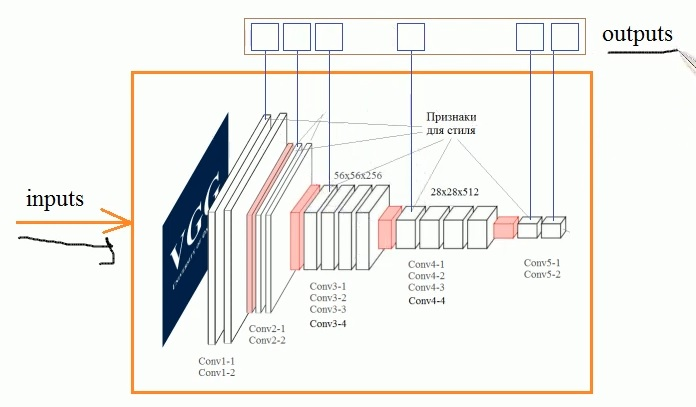

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image

In [2]:
upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

Saving img_style.jpg to img_style (3).jpg
Saving img.jpg to img (3).jpg


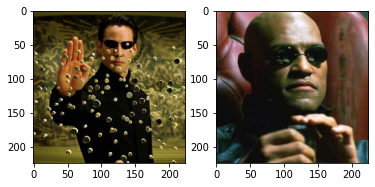

In [3]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_style)
plt.show()

In [4]:
x_img = keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0)) # RGB -> BGR
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0))

In [5]:
# BGR -> RGB
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0) # убираем нулевую ось
    # проверим действительно ли осталось 3 оси
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

In [7]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
    print(m)

model = keras.models.Model(vgg.input, model_outputs)

# не будем использовать полносвязную нейронную сеть на выходе, а веса будем использовать ImageNet
for layer in model.layers:
    layer.trainable = False
print(model.summary()) # вывод структуры НС в консоль

Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)
Tensor("block1_conv1/Relu:0", shape=(None, None, None, 64), dtype=float32)
Tensor("block2_conv1/Relu:0", shape=(None, None, None, 128), dtype=float32)
Tensor("block3_conv1/Relu:0", shape=(None, None, None, 256), dtype=float32)
Tensor("block4_conv1/Relu:0", shape=(None, None, None, 512), dtype=float32)
Tensor("block5_conv1/Relu:0", shape=(None, None, None, 512), dtype=float32)
Tensor("block5_conv2/Relu:0", shape=(None, None, None, 512), dtype=float32)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928   

In [9]:
# функция возвращает карты признаков для стиля и контента
def get_feature_representations(model):
    # batch compute content and style features
    style_outputs = model(x_style)
    content_outputs = model(x_img)

    # Get the style and content feature representations from our model
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [10]:
# функция вычисления потерь по контенту
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [11]:
# функция вычисления матрицы Грама
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

# функция определения потерь по стилю для определённого слоя
def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

# общая функция выяснения потерь
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [12]:
num_iterations=100
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

In [ ]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

# запуск алгоритма градиентного спуска
for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals) # ограничим пиксел изображения минимальными и максимальными значениями
    init_image.assign(clipped)
    
    # проверяем для какого условия у на проявились наименьшие потери
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))

In [ ]:
plt.imshow(best_img)
print(best_loss)

In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save('matrix.jpg')
files.download('matrix.jpg')